# Chemometrics
<br>
**Julien Wist / 2017 / Universidad del Valle**
<br>
**Andrés Bernal / 2017 / ???**

An up-to-date version of this notebook can be found here: https://github.com/jwist/chemometrics/

In [1]:
options(repr.plot.width=4, repr.plot.height=4)

In [2]:
# we load a few packages
library(ggplot2)
library(corrplot)
library(reshape2)
library(caret)
library(MASS) # for LDA
library(klaR) # for pls
library(pls)
library(e1071)# for pls
library(pROC) # for pls
library(vegan)
require(scales)
require(gridExtra);

corrplot 0.84 loaded
Loading required package: lattice

Attaching package: ‘pls’

The following object is masked from ‘package:caret’:

    R2

The following object is masked from ‘package:corrplot’:

    corrplot

The following object is masked from ‘package:stats’:

    loadings

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: permute
This is vegan 2.4-5

Attaching package: ‘vegan’

The following object is masked from ‘package:pls’:

    scores

The following object is masked from ‘package:klaR’:

    rda

The following object is masked from ‘package:caret’:

    tolerance

Loading required package: scales
Loading required package: gridExtra


## Let's load some NMR data

In [3]:
#rm(list=ls(all=TRUE))

load(url('https://github.com/jwist/chemometrics/raw/master/datasets/coffeeMulti.rda'))
load(url('https://github.com/jwist/chemometrics/raw/master/datasets/ppm.binned.rda'))


In [4]:
t<-coffeeMulti$gc$country; #levels(t)<-c("o", "c","o" )
# we perform ANOVA on the nmr data. 
#d <- data.frame("x"=I(as.matrix(coffeeMulti$nmrBin)),"country"=coffeeMulti$gc$country)
d <- data.frame("x"=I(as.matrix(coffeeMulti$nmrBin)),"country"=t)
colnames(d$x) <- round(ppm.binned,3) # put ppm of bins as tag for data column. This will be helpfull for tracking variables.
fit <- aov(x ~ country, data=d)
resultsF <- unlist( lapply(summary(fit),function(x) x[[4]][1]) ) # we extract F-values
# extract the p-value of K-W test for all NMR variables
#resultsK_W.p <- apply(d$x, 2, function(x) kruskal.test(x ~ coffeeMulti$gc$country)$p.value)
resultsK_W.p <- apply(d$x, 2, function(x) kruskal.test(x ~ t)$p.value)


# we look at some results to have an idea
b <- head(order(resultsF, decreasing = TRUE), 200) # select the most discriminant variable for further analysis
best <- b[1]
#best = 1150
d <- data.frame("x"=coffeeMulti$nmrBin[,best],"country"=t)
#d <- data.frame("x"=coffeeMulti$nmrBin[,best],"country"=coffeeMulti$gc$country)

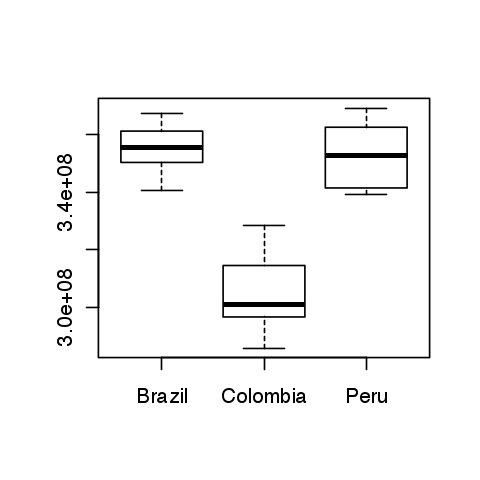

In [5]:
boxplot(tapply(d$x,d$country,function(x) x))

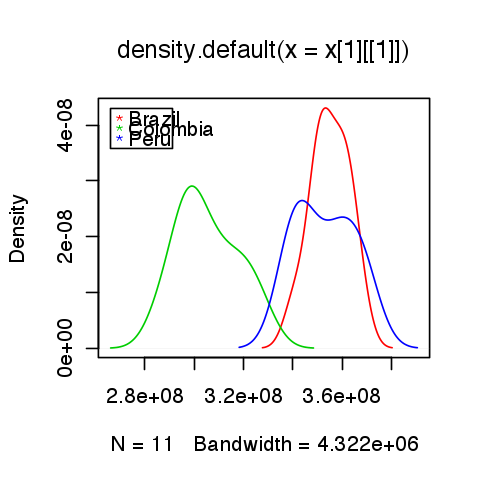

In [6]:
# here we plot the distribution for each class
x <- tapply(d$x,d$country,function(x) x)
xlims <- range(unlist(tapply(d$x,d$country,function(x) unlist(range(density(x)$x)))))
ylims <- range(unlist(tapply(d$x,d$country,function(x) unlist(range(density(x)$y)))))
plot(density(x[1][[1]]),type='l', xlim=xlims, ylim=ylims, col=2)
lines(density(x[2][[1]]), col=3)
lines(density(x[3][[1]]), col=4)
legend(min(xlims),max(ylims),levels(d$country), col=2:4, pch="*")

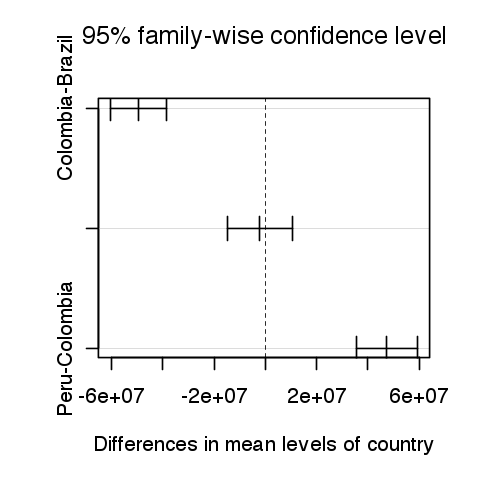

In [7]:
fit <- aov(as.matrix(d$x) ~ country, data=d)
#TukeyHSD(fit, "country", ordered = TRUE);
plot(TukeyHSD(fit, "country")); 

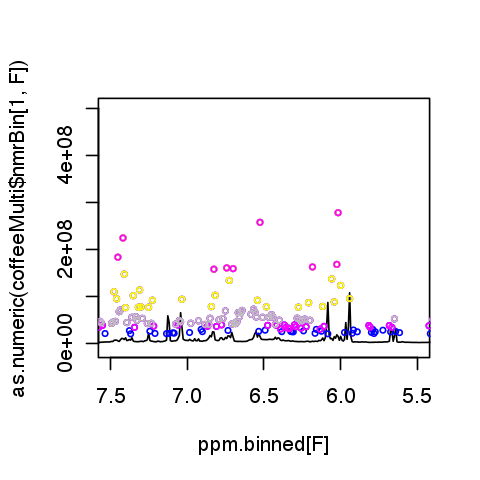

In [8]:
F <- resultsF > 4
index <- 1:length(resultsF)
plot(ppm.binned[F],as.numeric(coffeeMulti$nmrBin[1,F]), type="n", ylim=c(-1e7,5e8), xlim=c(7.5,5.5))
lines(ppm.binned,as.numeric(coffeeMulti$nmrBin[1,]), col=1)
for (i in c(4,6,8,15,30)) {
  F <- resultsF > i
  index <- 1:length(resultsF)
  points(ppm.binned[F],resultsF[F]*5e6,cex=0.5, col=i)
}

In [9]:
options(repr.plot.width=8, repr.plot.height=3)

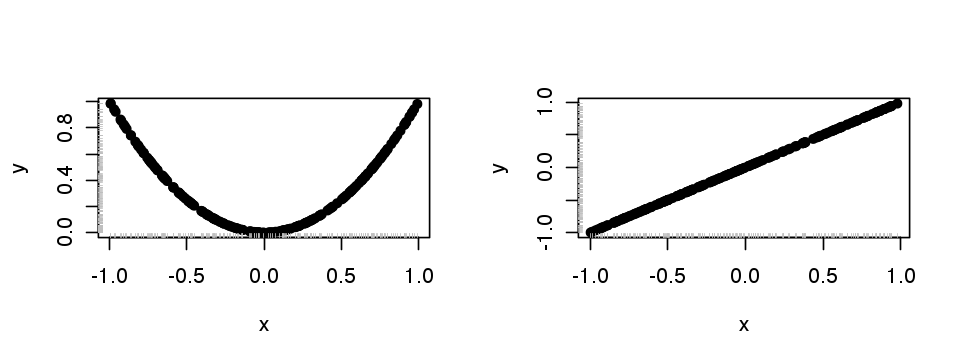

In [10]:
par(mfrow=c(1,2))

x <- runif(200,min=-1,max=1)
y <- x^2
plot(x,y,pch=16)
rug(x,side=1,col="grey")
rug(y,side=2,col="grey")
#cor(x,y);
#chisq.test(x,y) ;

x <- runif(200,min=-1,max=1)
y <- x
plot(x,y,pch=16)
rug(x,side=1,col="grey")
rug(y,side=2,col="grey")
#cor(x,y);
#chisq.test(x,y) ;

Despite in both cases $x$ and $y$ are dependent, in the left case they are completely uncorrelated. So being uncorrelated is not the same as being independent, but independant variables are uncorrelated. Two variables are considered independent when their joint probability distribution is equal to the product of their individual marginal probability distributions: $$P_{X,Y}(x,y)=P_X(x)P_Y(y)$$

Two variables are uncorrelated when their correlation coefficient is zero or when their covariance is equal to zero.


### high number of variable

- The number of available variables (predictors) is much higher that the number of observation
- overfitting 
- reduce the number of variables a task that is achieved by step-wise regression, etc.  



## multivariate analysis

However there are others and more robust alternatives to these methods that aknowledge the redundancy of information spanned by collinear predictors and try to convert collinearity of predictors (an issue) into reliability (a plusvalue). 


In [33]:
options(repr.plot.width=4, repr.plot.height=4)
load('/Users/jul/metabo/paper_IRMS/resultsF.rda')
load('/Users/jul/metabo/paper_IRMS/coffeeMulti.rda')
load('/Users/jul/metabo/paper_IRMS/ppm.binned.rda')
colnames(coffeeMulti$nmrBin) <- round(ppm.binned,3)
country <- coffeeMulti$gc$country 
irms <- abs(coffeeMulti$irms$mean) 
vite <- coffeeMulti$gc$vitE
caff <- coffeeMulti$gc$caffeine 
fumeth <- coffeeMulti$gc$furanmethanol
ffilter <- resultsF > 15
x <- cbind(irms,
           vite,
           caff,
           fumeth,
           as.matrix(coffeeMulti$nmrBin[,ffilter]))
is(x)

[1] "matrix"    "array"     "mMatrix"   "listI"     "output"    "input"    
[7] "mpinput"   "structure" "vector"

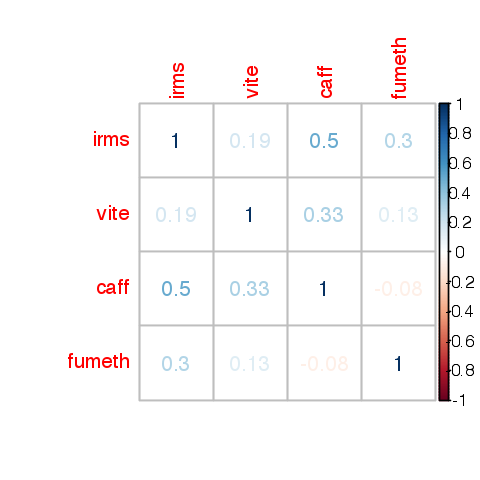

In [12]:
corrplot::corrplot(cor(cbind(irms, vite, caff, fumeth)),
                   method='number')


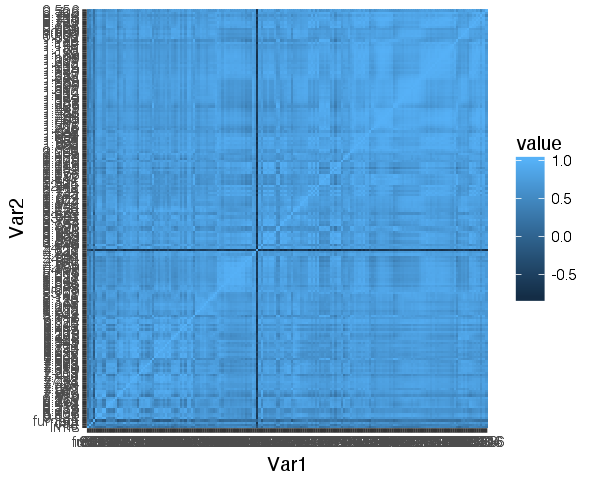

In [13]:
options(repr.plot.width=5, repr.plot.height=4)
qplot(x=Var1, y=Var2, data=melt(cor(x)), fill=value, geom="tile")

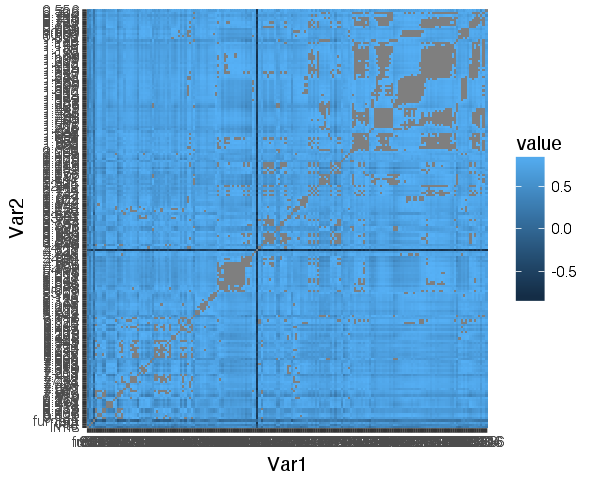

In [14]:
M <- cor(x)
M[M > 0.9] <- NA
qplot(x=Var1, y=Var2, data=melt(M), fill=value, geom="tile")


In [44]:
C <- findCorrelation(cor(x), 
                     cutoff = .90, 
                     verbose = FALSE)
#x <- x[ , -C ]

fvalues <- c(8.879,4.14,31.87,4.76,resultsF[ffilter])
# to ensure that both x and f-value with the same number of Var
fvalues <- fvalues[ -C ] 
x <- scale(x, center=TRUE)

FF <- c(7,20,22,24)
d <- data.frame("x"=I(as.matrix(x[-FF,])), "country"=country[-FF])
#d <- d[d$country!="Colombia",]

pca <- prcomp(d$x)


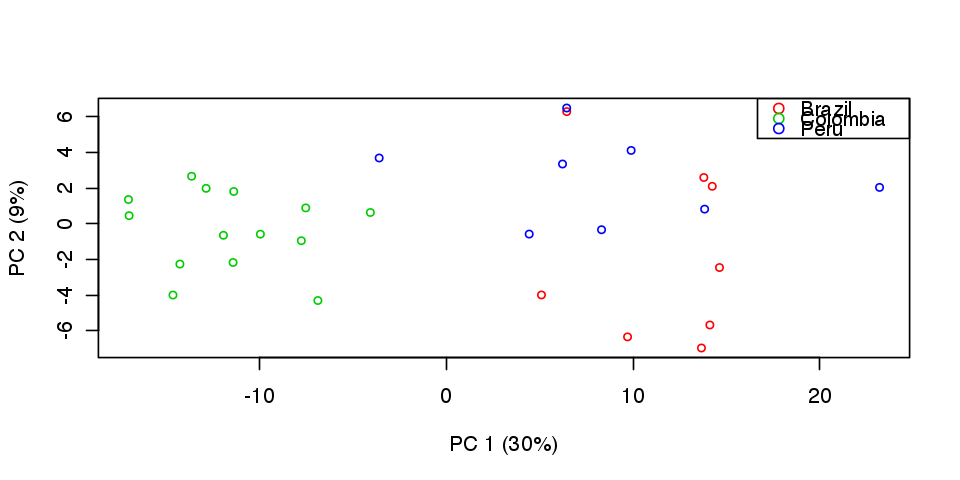

In [45]:
options(repr.plot.width=8, repr.plot.height=4)
pc <- c(1,2)
COLOR <- c(2:4)
ev <- c(round(pca$sdev[pc[1]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[2]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[3]]/sum(pca$sdev)*100,0))
plot(pca$x[,pc[1]], pca$x[,pc[2]], col=COLOR[d$country], cex=0.7, 
     xlab=paste0("PC ", pc[1], " (", ev[pc[1]], "%)"), 
     ylab=paste0("PC ", pc[2], " (", ev[pc[2]], "%)"))
legend("topright", legend=levels(country), col=COLOR, pch=1)

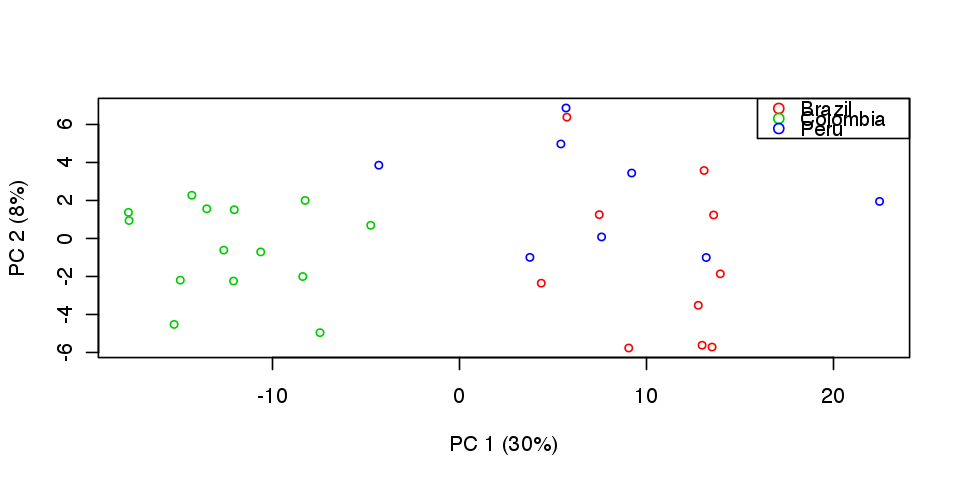

In [43]:
options(repr.plot.width=8, repr.plot.height=4)
pc <- c(1,2)
COLOR <- c(2:4)
ev <- c(round(pca$sdev[pc[1]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[2]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[3]]/sum(pca$sdev)*100,0))
plot(pca$x[,pc[1]], pca$x[,pc[2]], col=COLOR[d$country], cex=0.7, 
     xlab=paste0("PC ", pc[1], " (", ev[pc[1]], "%)"), 
     ylab=paste0("PC ", pc[2], " (", ev[pc[2]], "%)"))
legend("topright", legend=levels(country), col=COLOR, pch=1)

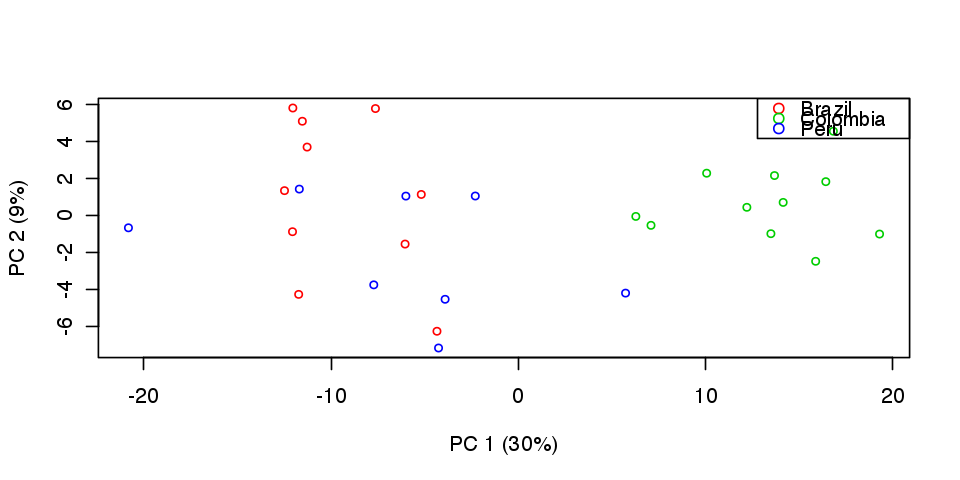

In [38]:
options(repr.plot.width=8, repr.plot.height=4)
pc <- c(1,2)
COLOR <- c(2:4)
ev <- c(round(pca$sdev[pc[1]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[2]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[3]]/sum(pca$sdev)*100,0))
plot(pca$x[,pc[1]], pca$x[,pc[2]], col=COLOR[d$country], cex=0.7, 
     xlab=paste0("PC ", pc[1], " (", ev[pc[1]], "%)"), 
     ylab=paste0("PC ", pc[2], " (", ev[pc[2]], "%)"))
legend("topright", legend=levels(country), col=COLOR, pch=1)

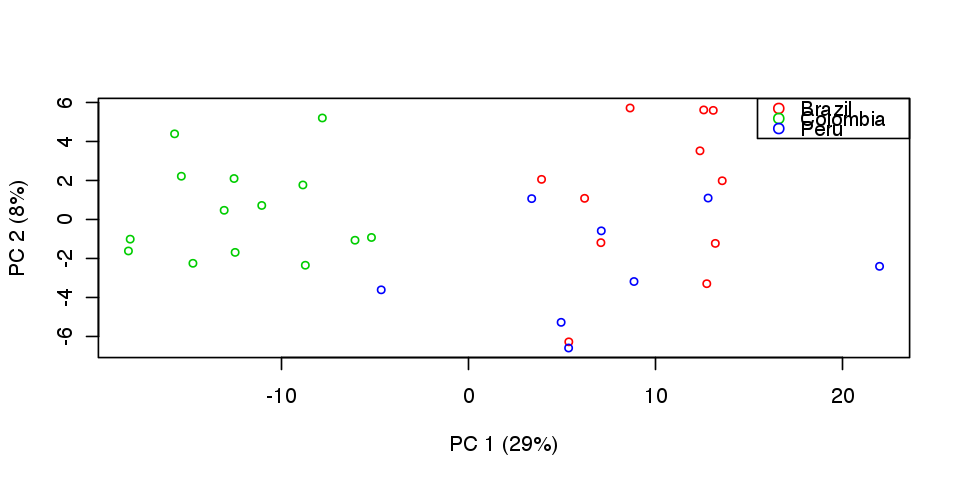

In [36]:
options(repr.plot.width=8, repr.plot.height=4)
pc <- c(1,2)
COLOR <- c(2:4)
ev <- c(round(pca$sdev[pc[1]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[2]]/sum(pca$sdev)*100,0),
        round(pca$sdev[pc[3]]/sum(pca$sdev)*100,0))
plot(pca$x[,pc[1]], pca$x[,pc[2]], col=COLOR[d$country], cex=0.7, 
     xlab=paste0("PC ", pc[1], " (", ev[pc[1]], "%)"), 
     ylab=paste0("PC ", pc[2], " (", ev[pc[2]], "%)"))
legend("topright", legend=levels(country), col=COLOR, pch=1)

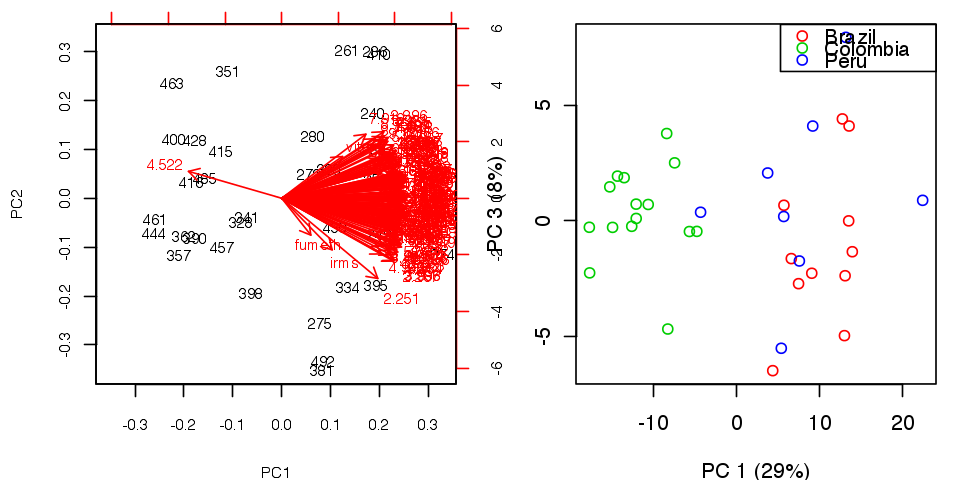

In [23]:
options(repr.plot.width=8, repr.plot.height=4)
pc <- c(1,3)
COLOR <- c(2:4)
PCH <- c(1,16)
pca <- prcomp(d$x)
#pca <- prcomp(d$x,scale=FALSE,center=TRUE)
layout(matrix(c(1,2), 1, 2, byrow = TRUE), widths=c(3,3), heights=c(1)) 
op <- par(mar = c(4,4,1,1))
biplot(pca,cex=0.7,cex.lab=0.7,cex.axis=0.7)
plot(pca$x[,pc[1]], pca$x[,pc[2]], col=COLOR[d$country], cex=PCH[1], xlab=paste0("PC ", pc[1], " (", round(pca$sdev[pc[1]]/sum(pca$sdev)*100,0), "%)"), ylab=paste0("PC ", pc[2], " (", round(pca$sdev[pc[2]]/sum(pca$sdev)*100,0), "%)"))
legend("topright", legend=levels(country), col=COLOR, pch=1)
par(op)

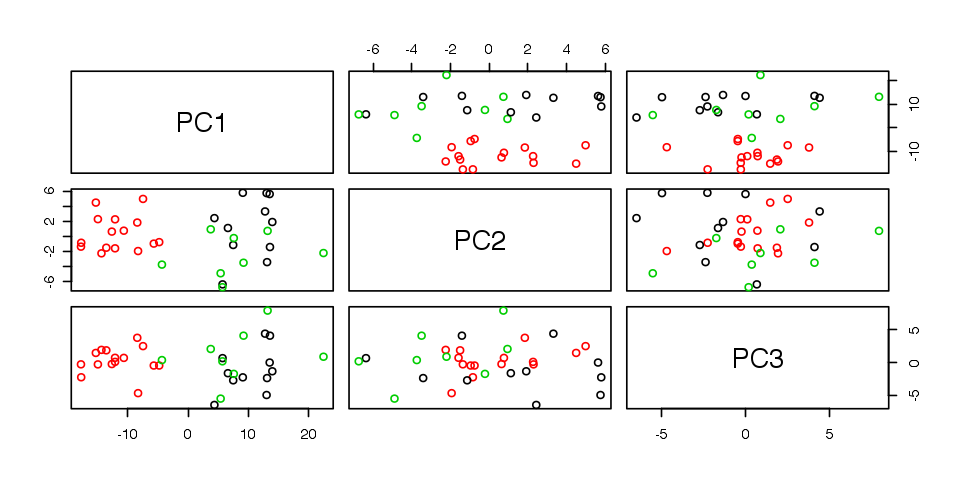

In [24]:
pairs(pca$x[,1:3],col=d$country)


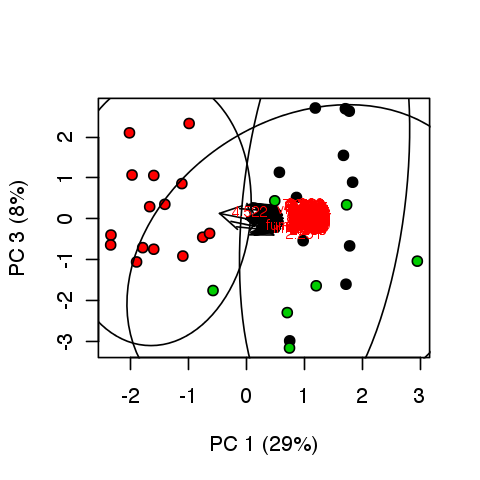

In [25]:
options(repr.plot.width=4, repr.plot.height=4)
prin_comp<-rda(d$x, scale=TRUE)
pca_scores<-scores(prin_comp)
plot(pca_scores$sites[,1],pca_scores$sites[,2], pch=21, bg=as.numeric(d$country),
    arrows(0,0,pca_scores$species[,1],pca_scores$species[,2],lwd=1,length=0.2),
    xlab=paste0("PC ", pc[1], " (", round(pca$sdev[pc[1]]/sum(pca$sdev)*100,0), "%)"), ylab=paste0("PC ", pc[2], " (", round(pca$sdev[pc[2]]/sum(pca$sdev)*100,0), "%)"))
ordiellipse(prin_comp,d$country,conf=0.99)
text(pca_scores$species[,1],pca_scores$species[,2],colnames(d$x),cex=0.7,pos=4,col="red")

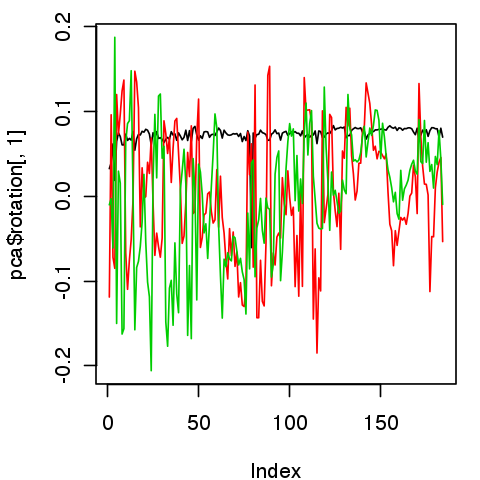

In [26]:
op <- par(mar = c(4,4,1,1))
plot(pca$rotation[,1], type='l', ylim=range(pca$rotation[,1:3]))
lines(pca$rotation[,2], type='l', col=2)
lines(pca$rotation[,3], type='l', col=3)
par(op)

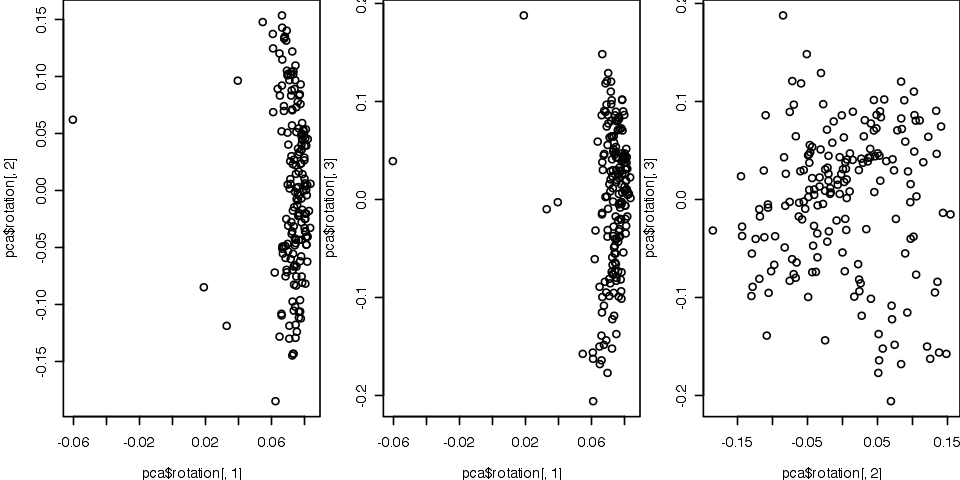

In [27]:
options(repr.plot.width=8, repr.plot.height=4)
layout(matrix(c(1,2,3), 1, 3, byrow = TRUE), 
       widths=c(3,3,3), 
       heights=c(1)) 
op <- par(mar = c(4,4,0,0))
plot(pca$rotation[,1],pca$rotation[,2]); 
plot(pca$rotation[,1],pca$rotation[,3]); 
plot(pca$rotation[,2],pca$rotation[,3])
par(op)

In [28]:
options(repr.plot.width=4, repr.plot.height=4)
aload <- abs(pca$rotation)
contrib <- sweep(aload, 2, colSums(aload), "/")

plot(fvalues[],contrib[,pc[1]],
     xlab="F-values calculated from ANOVA", 
     ylab=paste0("contribution to PC",pc[1]))
text(fvalues[],contrib[,pc[1]],colnames(d$x),cex=0.7,pos=4,col="red")
legend('topleft', 
       legend=paste("corr=",round(cor(fvalues,contrib[,pc[1]]),2)))

ERROR: Error in xy.coords(x, y, xlabel, ylabel, log): 'x' and 'y' lengths differ


ERROR: Error in text.default(fvalues[], contrib[, pc[1]], colnames(d$x), cex = 0.7, : plot.new has not been called yet


ERROR: Error in cor(fvalues, contrib[, pc[1]]): incompatible dimensions


In [29]:
x <- cbind(irms,vite,caff,fumeth,as.matrix(coffeeMulti$nmrBin[,ffilter]))
C <- findCorrelation(cor(x), cutoff = .90, verbose = FALSE)
fvalues <- c(8.879,4.14,31.87,4.76,resultsF[ffilter]) # we apply the filter
x <- scale(x, center=TRUE)
d <- data.frame("x"=I(as.matrix(x)), "country"=country)
rownames(d$x)<-1:nrow(d) #to have the numbers according to the index in the matrix
pca <- prcomp(d$x)
aload <- abs(pca$rotation)
contrib <- sweep(aload, 2, colSums(aload), "/")
op <- par(mar = c(4,4,0,0))

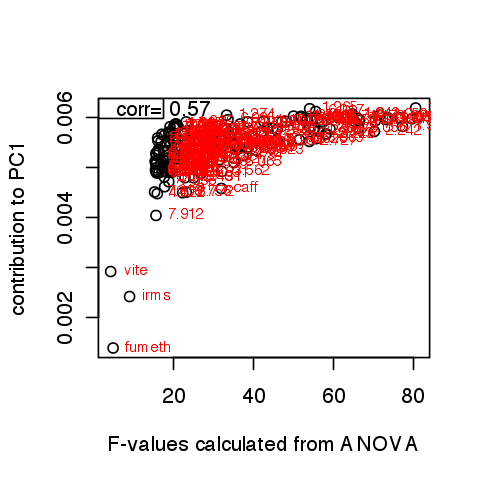

In [30]:

plot(fvalues[],contrib[,pc[1]],xlab="F-values calculated from ANOVA", ylab=paste0("contribution to PC",pc[1]))
text(fvalues[],contrib[,pc[1]],colnames(d$x),cex=0.7,pos=4,col="red")
legend('topleft', legend=paste("corr=",round(cor(fvalues,contrib[,pc[1]]),2)))
par(op)

### conclusions

- irms, gc-ms and nmr are not complementary
- the same molecules are detected and therefore no additional value is gained

## PLS

In [31]:
library(caret)
options(repr.plot.width=4, repr.plot.height=4)

In [32]:
m<-matrix(sample(0:140,140), nrow= 20,ncol =7, byrow="TRUE")

species<-c("1", "1", "1","1", "1", "1","1", "1", "1","1",
           "-1","-1","-1","-1","-1","-1","-1","-1","-1","-1")

M<-data.frame(m,species)
X<-m
Y<-as.numeric(species)


In [33]:
M[c(1,2,19,20),]

,X1,X2,X3,X4,X5,X6,X7,species
1,54,63,17,108,51,120,88,1
2,66,105,96,2,121,32,90,1
19,127,74,114,79,45,130,113,-1
20,33,119,37,40,82,68,0,-1


In [34]:
nf = dim(X)[1]
T = c()
P = c()
C = c()
W = c()

In [35]:
for (j in 1:nf) {
  w = (t(X) %*% Y) %*% solve(t(Y) %*% Y)
  w1 = t(w) %*% w
  w2 = abs(sqrt(w1))
  w = w %*% solve(w2)
  t = (X %*% w)
  t1 = t(t) %*% t
  c = t(Y) %*% t %*% solve(t1)
  c1 = t(c) %*% c
  u = Y %*% c %*% solve(c1)
  u1 = t(u) %*% u
  u2 = abs(sqrt(u1))
  p = (t(X) %*% t) %*% solve(t1)
  X = X - (t)%*%t(p)
  T = matrix(c(T, t))
  P = matrix(c(P, p))
  C = matrix(c(C, c))
  W = matrix(c(W, w))
}

In [36]:
T = matrix(T, ncol = nf)
T = scale(T, scale = TRUE, center = TRUE)
P = matrix(P, ncol = nf)
C = matrix(C, ncol = nf)
W = matrix(W, ncol = nf)


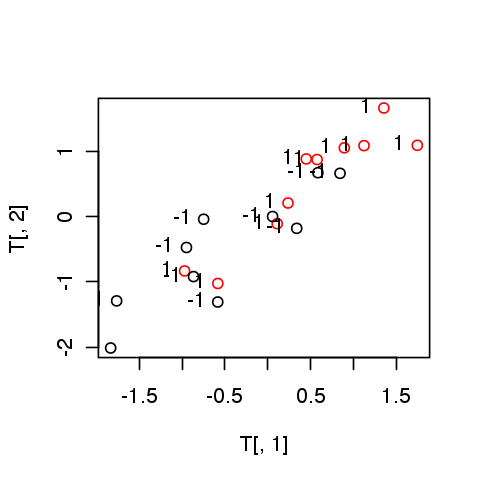

In [37]:
plot(T[,1], T[,2], col = factor(species))
text(T[,1], T[,2], species, pos = 2)


## o-PLS

In [38]:
m<-matrix(sample(6e6:7e6,140), nrow= 20,ncol =7, byrow="TRUE")

In [39]:
species<-c("1", "1", "1","1", "1", "1","1", "1", "1","1",
           "-1","-1","-1","-1","-1","-1","-1","-1","-1","-1")

M<-data.frame(m,species)
X<-m
Y<-as.numeric(species)
nf=15

T = c()
P = c()
C = c()
W = c()
Tortho = c()
Portho = c()
Wortho = c()
Cortho = c()

In [40]:
for (j in 1:nf) {
  w = (t(X) %*% Y) %*% solve(t(Y) %*% Y)
  w=w%*%solve(norm(w))
  t = (X %*% w) %*% solve(t(w) %*% w)
  c = t(Y) %*% t %*% solve(t(t) %*% t)
  u = Y %*% c %*% solve(t(c) %*% c)
  p = (t(X) %*% t) %*% solve(t(t) %*% t)
  wortho = p - w
  wortho= p - t(((t(w)%*%p)%*% solve(t(w)%*%w))%*% t(w))
  wortho= wortho%*%solve(norm(wortho))
  tortho = X %*% wortho %*% solve(t(wortho) %*% wortho)
  portho = t(X) %*% tortho %*% solve(t(tortho) %*% tortho)
  cortho = t(Y) %*% tortho %*% solve(t(tortho) %*% tortho)
  X = X - tortho %*% t(portho)
  T = matrix(c(T, t))
  P = matrix(c(P, p))
  C = matrix(c(C, c))
  W = matrix(c(W, w))
  Tortho = matrix(c(Tortho, tortho))
  Portho = matrix(c(Portho, portho))
  Wortho = matrix(c(Wortho, wortho))
  Cortho = matrix(c(Cortho, cortho))
}

In [41]:
T = matrix(T, ncol = nf)
T = scale(T, scale = TRUE, center = TRUE)
P = matrix(P, ncol = nf)
C = matrix(C, ncol = nf)
W = matrix(W, ncol = nf)
Tortho = matrix(Tortho, ncol = nf)
Tortho = scale(Tortho, scale = TRUE, center = TRUE)
Portho = matrix(Portho, ncol = nf)
Wortho = matrix(Wortho, ncol = nf)
Xortho = Tortho %*% t(Portho)

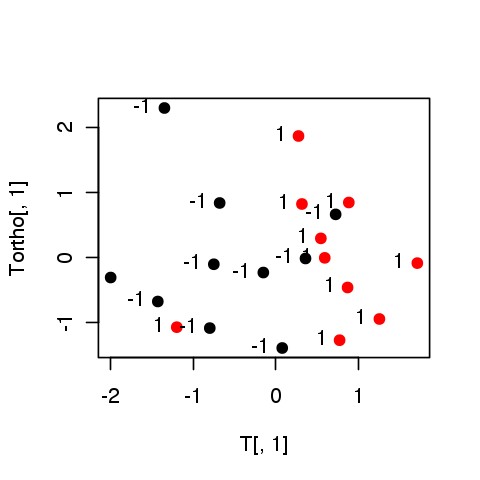

In [42]:
plot(T[,1], Tortho[, 1], pch = 19, col=factor(species))
text(T[, 1], Tortho[,1],species, cex=1, pos=2)

In [51]:
m<-matrix(sample(6e6:7e6,14000), nrow= 20,ncol =700, byrow="TRUE")

In [52]:
species<-c("1", "1", "1","1", "1", "1","1", "1", "1","1",
           "-1","-1","-1","-1","-1","-1","-1","-1","-1","-1")

M<-data.frame(m,species)
X<-m
Y<-as.numeric(species)
nf=15

T = c()
P = c()
C = c()
W = c()
Tortho = c()
Portho = c()
Wortho = c()
Cortho = c()
for (j in 1:nf) {
  w = (t(X) %*% Y) %*% solve(t(Y) %*% Y)
  w=w%*%solve(norm(w))
  t = (X %*% w) %*% solve(t(w) %*% w)
  c = t(Y) %*% t %*% solve(t(t) %*% t)
  u = Y %*% c %*% solve(t(c) %*% c)
  p = (t(X) %*% t) %*% solve(t(t) %*% t)
  wortho = p - w
  wortho= p - t(((t(w)%*%p)%*% solve(t(w)%*%w))%*% t(w))
  wortho= wortho%*%solve(norm(wortho))
  tortho = X %*% wortho %*% solve(t(wortho) %*% wortho)
  portho = t(X) %*% tortho %*% solve(t(tortho) %*% tortho)
  cortho = t(Y) %*% tortho %*% solve(t(tortho) %*% tortho)
  X = X - tortho %*% t(portho)
  T = matrix(c(T, t))
  P = matrix(c(P, p))
  C = matrix(c(C, c))
  W = matrix(c(W, w))
  Tortho = matrix(c(Tortho, tortho))
  Portho = matrix(c(Portho, portho))
  Wortho = matrix(c(Wortho, wortho))
  Cortho = matrix(c(Cortho, cortho))
}
T = matrix(T, ncol = nf)
T = scale(T, scale = TRUE, center = TRUE)
P = matrix(P, ncol = nf)
C = matrix(C, ncol = nf)
W = matrix(W, ncol = nf)
Tortho = matrix(Tortho, ncol = nf)
Tortho = scale(Tortho, scale = TRUE, center = TRUE)
Portho = matrix(Portho, ncol = nf)
Wortho = matrix(Wortho, ncol = nf)
Xortho = Tortho %*% t(Portho)


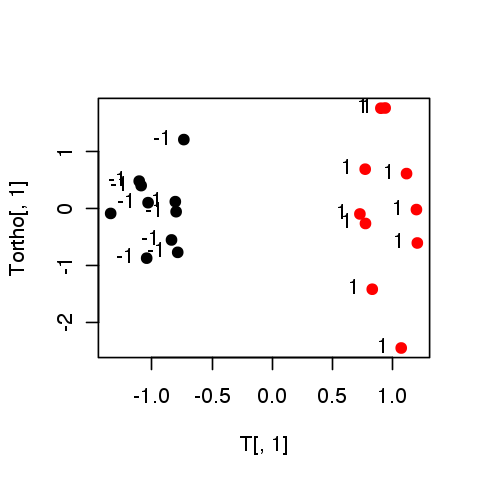

In [53]:
plot(T[,1], Tortho[, 1], pch = 19, col=factor(species))
text(T[, 1], Tortho[,1],species, cex=1, pos=2)

## Conclusions

- this is a code for teaching (not validated)
- we can get inspiration for creating a new publication style

<center><img src=".https://raw.githubusercontent.com/jwist/chemometrics/master/img/cloud3-04.png" width="500"></center>


In [46]:
#library(devtools)
#install_github("jwist/rLims")
library(rLims)
account <- list(server='mylims.univalle.edu.co',user='jessica.medina@correounivalle.edu.co',key='PDfEZzKo3K')
metaData <- lims.getUserSamplesMetaData(account=account)
metaData <- lims.selectSamples(metaData,c(7:8))
Filter <- list('experiment'=c('noesygpps1dcomp'))
data <- lims.getSpectra(metaData, Filter=Filter,OP='AND',dry=FALSE)
plot(data$spectra[[2]])
#dataSet <- lims.createDataSet(data)


Loading required package: rjson

Attaching package: 'rLims'

The following object is masked from 'package:ggplot2':

    lims

Warning message:
In lims.getParameters(entries): NA found in parameters, please check

[1] "number of spectra ordered by experiment type:"

                     cpmgpr1dcomp     hmbcgplpndqf  hsqcdietgpsisp2 
               3              104                2                2 
        mlevphpr  noesygpphwgx1jw      noesygppr1d noesygpps1d.comp 
               2                2               66                2 
 noesygpps1dcomp             zg30           zgpg30 
              96                1                2 
[1] "number of spectra ordered by solvents:"

                        CDCl3 COFFEEcalctemp     COFFEEmeoh            D2O 
             2              4              5             78             11 
        H2OD2O           MeOD 
           165             17 
[1] "number of spectra ordered by nucleus:"

13C  1H   C 
  2 278   2 
[1] "number of spectra ordered by temperature:"

  300 300.1 300.2 300.3 300.5 
  246    18     9     2     1 
[1] "total number of spectra:  282"


Warning message:
In file(file, "rt"): unable to connect to 'mylims.univalle.edu.co' on port 80.

ERROR: Error in file(file, "rt"): cannot open the connection


ERROR: Error in data$spectra: object of type 'closure' is not subsettable
